In [73]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Load dataset
df = pd.read_csv("project-data.csv", sep=";", skipinitialspace=True)

# Display first 5 rows
df.head()


,category,age,sex,albumin,alkaline_phosphatase,alanine_aminotransferase,aspartate_aminotransferase,bilirubin,cholinesterase,cholesterol,creatinina,gamma_glutamyl_transferase,protein
0,no_disease,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69
1,no_disease,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,no_disease,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,no_disease,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,no_disease,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


**Step 2: Data Cleaning & Column Formatting**

In [76]:
# Clean column names
df.columns = df.columns.str.strip()

# Remove spaces inside column values (if any)
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Replace wrong NA formats and convert numeric columns
df.replace(["NA", "NAN", "nan", "NA ", "NA    "], np.nan, inplace=True)

# Convert numeric columns
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

# Show missing values
print("Missing values:")
print(df.isnull().sum())


Missing values:
category                       0
age                            0
sex                            0
albumin                        1
alkaline_phosphatase          18
alanine_aminotransferase       1
aspartate_aminotransferase     0
bilirubin                      0
cholinesterase                 0
cholesterol                   10
creatinina                     0
gamma_glutamyl_transferase     0
protein                        1
dtype: int64


**Step 3: Handle Missing Values**

In [78]:
# Fill missing numeric values with median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

print("✅ Missing values after filling:")
print(df.isnull().sum())


✅ Missing values after filling:
category                      0
age                           0
sex                           0
albumin                       0
alkaline_phosphatase          0
alanine_aminotransferase      0
aspartate_aminotransferase    0
bilirubin                     0
cholinesterase                0
cholesterol                   0
creatinina                    0
gamma_glutamyl_transferase    0
protein                       0
dtype: int64


**EDA Code**



**1️⃣ Target Variable Distribution**

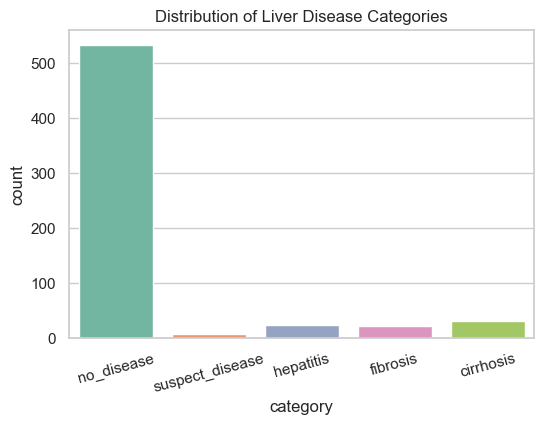

In [79]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['category'], palette='Set2')
plt.title("Distribution of Liver Disease Categories")
plt.xticks(rotation=15)
plt.show()


**2️⃣ Gender Distribution**

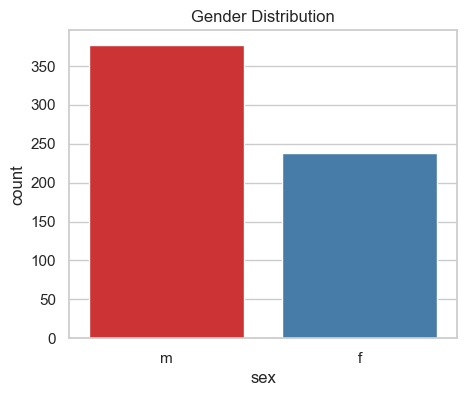

In [80]:
plt.figure(figsize=(5,4))
sns.countplot(x=df['sex'], palette='Set1')
plt.title("Gender Distribution")
plt.show()


**3️⃣ Numerical Feature Summary (Boxplots)**

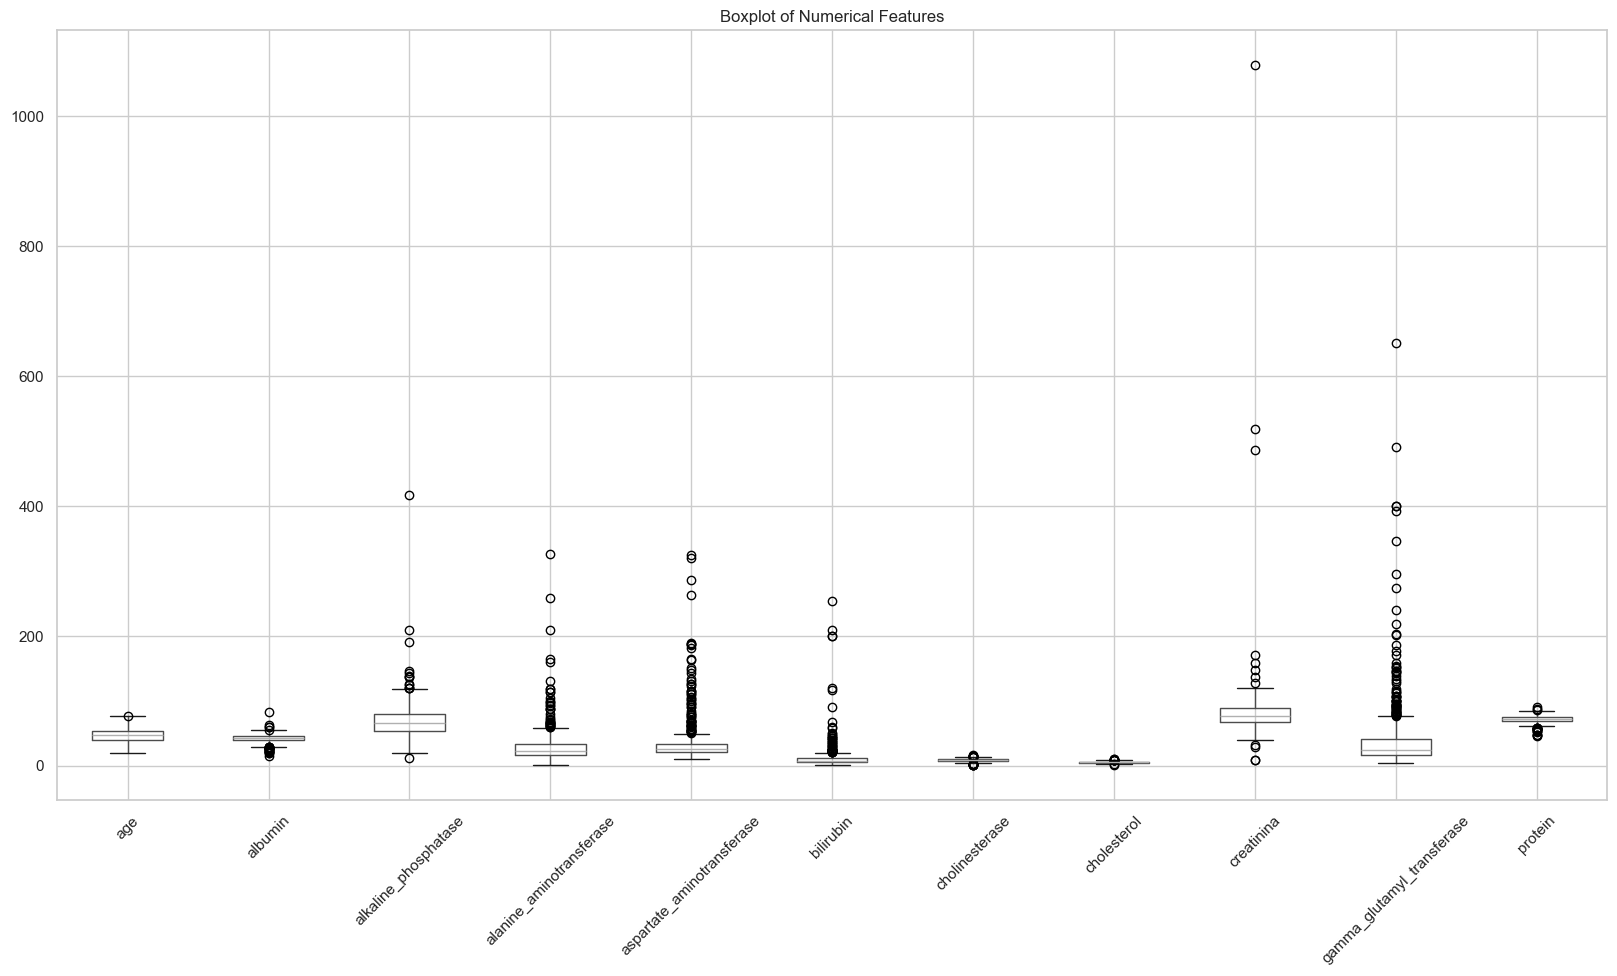

In [81]:
num_cols = df.select_dtypes(include=['float64','int64']).columns
plt.figure(figsize=(20,10))
df[num_cols].boxplot()
plt.title("Boxplot of Numerical Features")
plt.xticks(rotation=45)
plt.show()


**4️⃣ Correlation Heatmap**

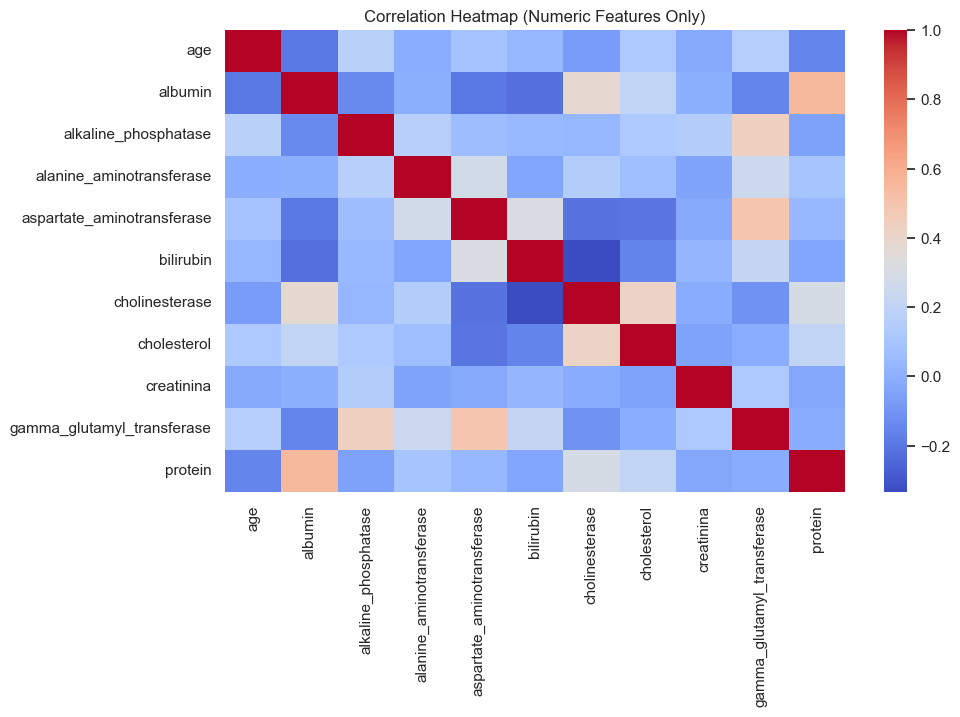

In [83]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64','float64'])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


**5️⃣ Category vs Key Markers**

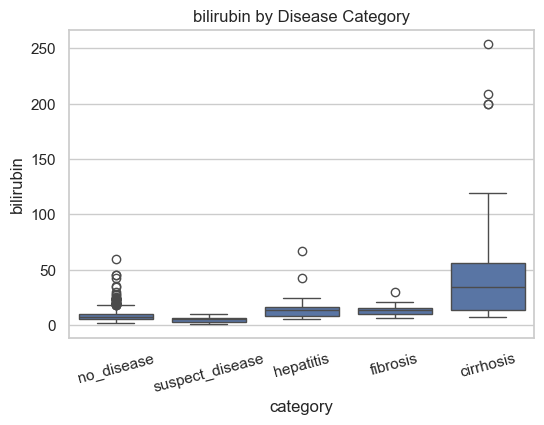

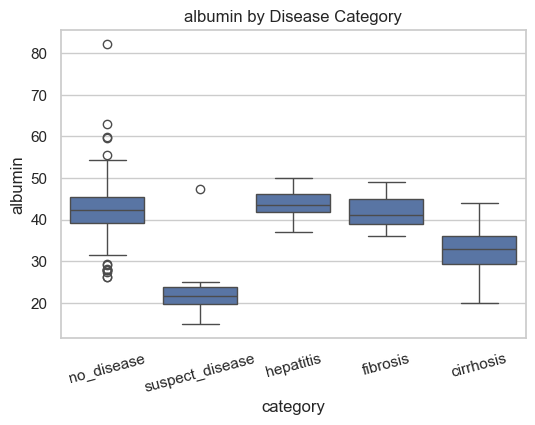

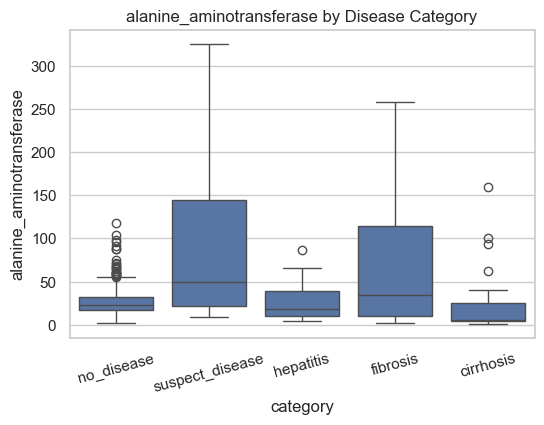

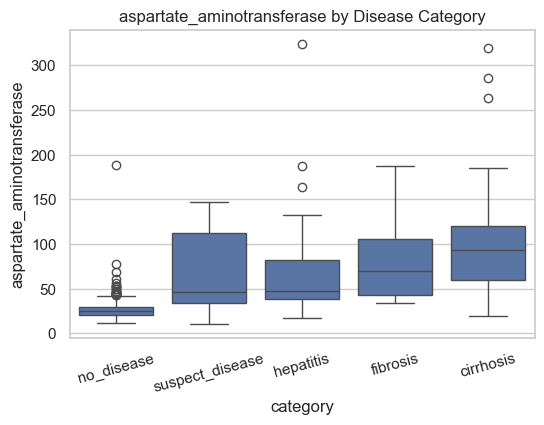

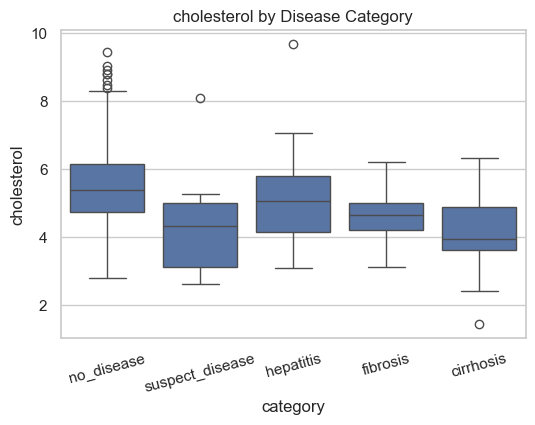

In [84]:
important_cols = ['bilirubin','albumin','alanine_aminotransferase','aspartate_aminotransferase','cholesterol']

for col in important_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df['category'], y=df[col])
    plt.title(f"{col} by Disease Category")
    plt.xticks(rotation=15)
    plt.show()


**Model Building Pipeline.**

**1. Encode Categorical Columns**

In [85]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['category'] = le.fit_transform(df['category'])


**2.Define X (features) & y (target)**

In [86]:
X = df.drop(columns=['category'])
y = df['category']


**3. Train-Test Split**

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(X_train.shape, X_test.shape)


(492, 12) (123, 12)


**4️. Handle Class Imbalance (SMOTE)**

In [88]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42, k_neighbors=2)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print(y_train.value_counts(), "\n")
print(y_train_res.value_counts())


category
3    426
0     24
2     19
1     17
4      6
Name: count, dtype: int64 

category
1    426
3    426
0    426
2    426
4    426
Name: count, dtype: int64


**5️.Feature Scaling**

In [89]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print("✅ Scaling Completed")


✅ Scaling Completed


**Train & Evaluate 5 Models**

In [93]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import time

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)": SVC(kernel='rbf', probability=True),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42)
}

results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train_scaled, y_train_res)   # use SMOTE balanced data for training
    y_pred = model.predict(X_test_scaled)    # test on original data
    end = time.time()

    results.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 4),
        "Precision (Macro)": round(precision_score(y_test, y_pred, average='macro'), 4),
        "Recall (Macro)": round(recall_score(y_test, y_pred, average='macro'), 4),
        "F1 Score (Macro)": round(f1_score(y_test, y_pred, average='macro'), 4),
        "Time (s)": round(end-start, 3)
    })

results_df = pd.DataFrame(results).sort_values(by="F1 Score (Macro)", ascending=False)
results_df


,Model,Accuracy,Precision (Macro),Recall (Macro),F1 Score (Macro),Time (s)
4,Random Forest,0.9350,0.8339,0.6567,0.6826,3.115
0,Logistic Regression,0.9024,0.5630,0.7255,0.6230,0.090
3,Decision Tree,0.9024,0.5611,0.5796,0.5668,0.046
1,KNN,0.8699,0.5132,0.6550,0.5558,0.040
2,SVM (RBF),0.9106,0.4134,0.5125,0.4534,0.519


**Step-2:Hyperparameter Tuning (RF)**

In [94]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_scaled, y_train_res)

print("✅ Best Parameters:", grid.best_params_)

best_rf = grid.best_estimator_

y_pred_best = best_rf.predict(X_test_scaled)

print("\nAccuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
✅ Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Accuracy: 0.9186991869918699

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.33      0.25      0.29         4
           2       0.50      0.20      0.29         5
           3       0.95      0.99      0.97       107
           4       1.00      1.00      1.00         1

    accuracy                           0.92       123
   macro avg       0.69      0.62      0.64       123
weighted avg       0.90      0.92      0.91       123


Confusion Matrix:
 [[  4   1   0   1   0]
 [  2   1   0   1   0]
 [  0   1   1   3   0]
 [  0   0   1 106   0]
 [  0   0   0   0   1]]


**Step-3:Feature Importance Plot**

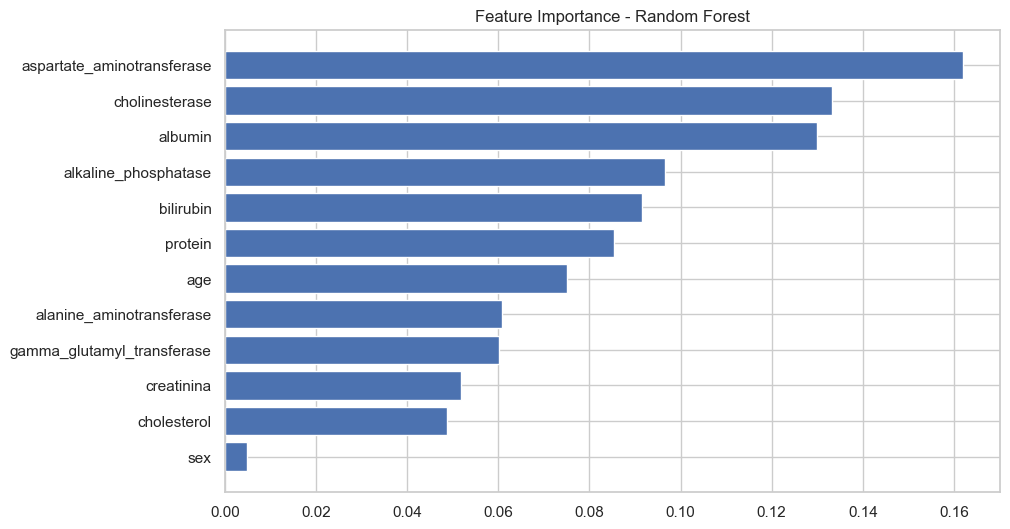

,Feature,Importance
5,aspartate_aminotransferase,0.162033
7,cholinesterase,0.133345
2,albumin,0.129903
3,alkaline_phosphatase,0.096477
6,bilirubin,0.091595
11,protein,0.085403
0,age,0.075113
4,alanine_aminotransferase,0.060702
10,gamma_glutamyl_transferase,0.060157
9,creatinina,0.051786


In [96]:

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance - Random Forest")
plt.show()

feature_importances
